# Head

In [ ]:
import sys
sys.path.append("clustering")
import os
from utils import get_data_dir

# Paper-abstract-based classification

In [2]:
import json
import random
from itertools import combinations
import pandas as pd
import math

import random
import json

def load_random_samples(file_path, sample_size):
    """
    从 JSON 文件中随机抽取指定数量的样本，避免完整遍历文件。
    
    Args:
        file_path (str): JSON 文件路径。
        sample_size (int): 随机抽样的样本数量。

    Returns:
        list: 抽样的记录。
    """
    # 估算文件总行数
    with open(file_path, 'r', encoding='utf-8') as f:
        print("Estimating total lines...")
        total_lines = sum(1 for _ in f)  # 仅计数，不存储内容
        print(f"Total lines: {total_lines}")

    # 随机选择行号
    random_indices = sorted(random.sample(range(total_lines), min(sample_size, total_lines)))

    # 按行号采样
    selected_samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        print("Sampling...")
        current_line = 0
        for target_idx in random_indices:
            while current_line < target_idx:  # 跳过非目标行
                f.readline()
                current_line += 1
            line = f.readline().strip()  # 读取目标行
            selected_samples.append(json.loads(line))
            current_line += 1
        print("Sampling complete.")
    
    return selected_samples

def prepare_data_from_json(samples, same_Scopus_label_ratio=0.5, same_cluster_label_ratio=0.5, total_pairs=1000):
    """
    从 JSON 文件中随机抽样构建数据对，严格控制 same_Scopus_label 和 same_cluster_label 的比例。
    
    Args:
        samples (list): 从JSON中抽取的样本。
        same_Scopus_label_ratio (float): `same_Scopus_label=1` 的目标比例，范围 [0, 1]。
        same_cluster_label_ratio (float): `same_cluster_label=1` 的目标比例，范围 [0, 1]。
        total_pairs (int): 总样本对数量。
        sample_size (int): 每次随机抽取的样本数量。

    Returns:
        pd.DataFrame: 包含 abstract_1, abstract_2, same_Scopus_label, same_cluster_label 的数据集。
    """
    # 检查 sample_size 是否足够生成足够的组合
    sample_size = len(samples)
    max_combinations = math.comb(sample_size, 2)
    if max_combinations < total_pairs:
        raise ValueError(f"Sample size {sample_size} is too small to generate {total_pairs} pairs. "
                         f"Maximum possible pairs with sample size {sample_size} is {max_combinations}.")


    # 计算每种组合的目标数量
    target_counts = {
        (1, 1): int(total_pairs * same_Scopus_label_ratio * same_cluster_label_ratio),
        (1, 0): int(total_pairs * same_Scopus_label_ratio * (1 - same_cluster_label_ratio)),
        (0, 1): int(total_pairs * (1 - same_Scopus_label_ratio) * same_cluster_label_ratio),
        (0, 0): int(total_pairs * (1 - same_Scopus_label_ratio) * (1 - same_cluster_label_ratio)),
    }

    # 初始化存储结果的列表
    pairs = {key: [] for key in target_counts.keys()}

    # 构建数据对
    while not all(len(pairs[k]) == target_counts[k] for k in target_counts.keys()):
        two_row = random.sample(samples, 2)
        row1 = two_row[0]
        row2 = two_row[1]
        Scopus_same = 1 if row1['Scopus_label'] == row2['Scopus_label'] else 0
        cluster_same = 1 if row1['cluster_label'] == row2['cluster_label'] else 0
        pair_key = (Scopus_same, cluster_same)

        # 添加到对应类别
        if len(pairs[pair_key]) < target_counts[pair_key]:
            pairs[pair_key].append({
                "abstract_1": row1["abstract"],
                "abstract_2": row2["abstract"],
                "same_Scopus_label": Scopus_same,
                "same_cluster_label": cluster_same
            })

    # 合并所有组合的数据对
    final_pairs = [pair for key in pairs for pair in pairs[key]]
    random.shuffle(final_pairs)  # 打乱顺序

    return pd.DataFrame(final_pairs)

In [3]:
import sys
sys.path.append("clustering")
import os
from utils import get_data_dir

dataset_path = os.path.join(get_data_dir(), "2010s","dataset.json")

data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [4]:
# 随机抽取样本
samples = load_random_samples(dataset_path, sample_size=10000)

Estimating total lines...
Total lines: 23322430
Sampling...
Sampling complete.


In [5]:
samples

[{'PaperID': 2943191526,
  'abstract': 'Abstract     The ends of nucleic acids oligomers alter the statistics of interior nonspecific ligand binding and act as binding sites with altered properties. While the former aspect of “end effects” has received much theoretical attention in the literature, the physical nature of end-binding, and hence its potential impact on a wide range of studies with oligomers, remains poorly known. Here, we report for the first time end-binding to DNA using a model helix-turn-helix motif, the DNA-binding domain of ETV6, as a function of DNA sequence length. Spectral analysis of ETV6 intrinsic tryptophan fluorescence by singular value decomposition showed that end-binding to nonspecific fragments was negligible at >0.2 kbp and accumulated to 8% of total binding to 23-bp oligomers. The affinity for end-binding was insensitive to salt but tracked the affinity of interior binding, suggesting translocation from interior sites rather than free solution as its mec

In [6]:
pair_df = prepare_data_from_json(samples, same_Scopus_label_ratio=0.5, same_cluster_label_ratio=0.5, total_pairs=10000)

In [7]:
pair_df

,abstract_1,abstract_2,same_Scopus_label,same_cluster_label
0,Complementarity between one-particle visibilit...,Endothelial cells express several types of int...,0,0
1,Malaria is still an important parasitic infect...,The atomic mass difference of (163)Ho and (163...,0,0
2,Research suggests that more than half of all e...,3051Background: The implementation of mammogra...,1,0
3,Ultrananocrystalline diamond/hydrogenated amor...,Abstract Two kinds of bio-chars derived fr...,0,1
4,In this paper the detailed analysis of thermal...,"Over the last years, extreme weather events ha...",1,0
...,...,...,...,...
9995,Background Stevens-Johnson Syndrome (SSJ) an...,Eosinophils can regulate local and systemic in...,1,1
9996,Jamaican athletes are prominent in sprint runn...,A compact sensing pixel for the determination ...,0,0
9997,Abstract Objective Insulin-like growth f...,There seems to be confusion among doctors rega...,1,1
9998,This paper is dedicated to the higher educatio...,AbstractUsing data from the National Longitudi...,1,1


In [8]:
pair_df['same_Scopus_label'].value_counts()

same_Scopus_label
0    5000
1    5000
Name: count, dtype: int64

In [9]:
pair_df['same_cluster_label'].value_counts()

same_cluster_label
0    5000
1    5000
Name: count, dtype: int64

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_features(samples, pair_df):
    """
    使用 TF-IDF 提取特征并计算摘要对的组合特征。
    
    Args:
        pair_df (pd.DataFrame): 包含 abstract_1 和 abstract_2 的数据集。

    Returns:
        np.ndarray: 组合特征数组。
    """
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    # 将所有摘要拼接用于训练 TF-IDF
    all_abstracts = [sample['abstract'] for sample in samples]
    vectorizer.fit(all_abstracts)

    # 计算组合特征（可以尝试其他方法）
    tfidf_abstract_1 = vectorizer.transform(pair_df['abstract_1'])
    tfidf_abstract_2 = vectorizer.transform(pair_df['abstract_2'])
    sum_features = tfidf_abstract_1 + tfidf_abstract_2
    diff_features = np.abs(tfidf_abstract_1 - tfidf_abstract_2)
    cosine_features = cosine_similarity(tfidf_abstract_1, tfidf_abstract_2).diagonal().reshape(-1, 1)
    
    # 拼接特征
    combined_features = np.hstack([sum_features.toarray(), diff_features.toarray(), cosine_features])
    return combined_features

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
# feature extraction using tf-idf, shared by all models
X = extract_features(samples, pair_df)

In [12]:
from sklearn.model_selection import train_test_split
label_column = "same_Scopus_label"

y = pair_df[label_column]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       996
           1       0.72      0.68      0.70      1004

    accuracy                           0.70      2000
   macro avg       0.71      0.71      0.70      2000
weighted avg       0.71      0.70      0.70      2000



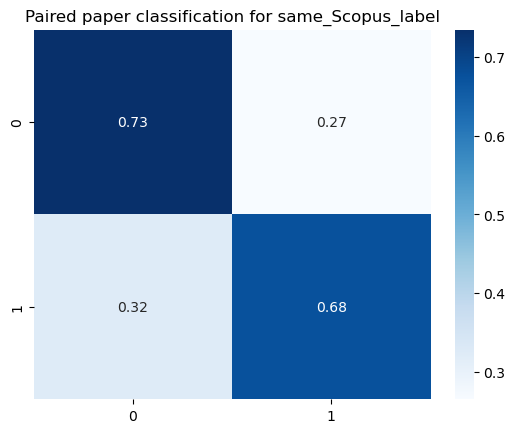

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
# evluation
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title(f"Paired paper classification for {label_column}")
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
label_column = "same_cluster_label"

y = pair_df[label_column]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0       0.63      0.68      0.66      1001
           1       0.65      0.60      0.63       999

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



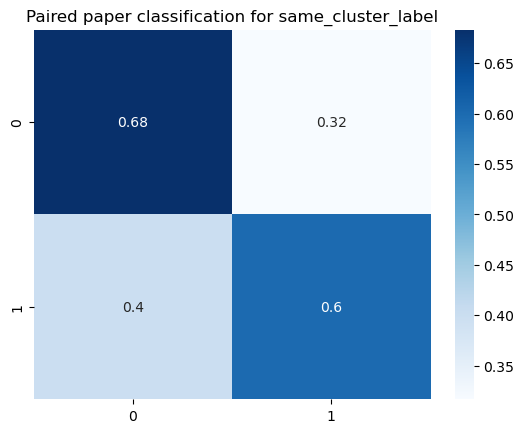

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 评估模型性能
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title(f"Paired paper classification for {label_column}")
plt.show()

# Journal-title-based classification

In [2]:
import os
import pandas as pd

cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))
venue_df = pd.read_parquet(os.path.join(get_data_dir(),"MAG_venue.parquet"))
cluster_df = pd.merge(cluster_df, venue_df['OriginalVenue'], left_index=True, right_index=True)
cluster_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,OriginalVenue
VID,,,,,,,,,,
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711,PLOS ONE
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494,Nature
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081,Proceedings of the National Academy of Science...
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582,Science
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758,Journal of the American Chemical Society
...,...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015,The internet journal of the third world medicine
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642,Publications of The English Goethe Society
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660,Peritia


In [11]:
import random

def prepare_journal_pairs(cluster_df, same_Scopus_label_ratio=0.5, same_movMF_label_ratio=0.5, total_pairs=1000):
    """
    从 cluster_df 中随机抽样构建期刊对，严格控制 same_Scopus_label 和 same_movMF_label 的比例。
    
    Args:
        cluster_df (pd.DataFrame): 包含期刊信息的数据集。
        same_Scopus_label_ratio (float): `same_Scopus_label=1` 的目标比例，范围 [0, 1]。
        same_movMF_label_ratio (float): `same_movMF_label=1` 的目标比例，范围 [0, 1]。
        total_pairs (int): 总样本对数量。

    Returns:
        pd.DataFrame: 包含 OriginalVenue_1, OriginalVenue_2, same_Scopus_label, same_movMF_label 的数据集。
    """
    # 计算每种组合的目标数量
    target_counts = {
        (1, 1): int(total_pairs * same_Scopus_label_ratio * same_movMF_label_ratio),
        (1, 0): int(total_pairs * same_Scopus_label_ratio * (1 - same_movMF_label_ratio)),
        (0, 1): int(total_pairs * (1 - same_Scopus_label_ratio) * same_movMF_label_ratio),
        (0, 0): int(total_pairs * (1 - same_Scopus_label_ratio) * (1 - same_movMF_label_ratio)),
    }

    # 初始化存储结果的列表
    pairs = {key: [] for key in target_counts.keys()}

    # 构建数据对
    total_target_pairs = sum(target_counts.values())
    progress_interval = total_target_pairs // 10  # 每完成10%的进度提示一次
    current_pairs = 0

    while not all(len(pairs[k]) == target_counts[k] for k in target_counts.keys()):
        two_row = cluster_df.sample(2, replace=False)
        row1 = two_row.iloc[0]
        row2 = two_row.iloc[1]
        Scopus_same = 1 if row1['Scopus_label'] == row2['Scopus_label'] else 0
        movMF_same = 1 if row1['movMF_label'] == row2['movMF_label'] else 0
        pair_key = (Scopus_same, movMF_same)

        # 添加到对应类别
        if len(pairs[pair_key]) < target_counts[pair_key]:
            pairs[pair_key].append({
                "OriginalVenue_1": row1["OriginalVenue"],
                "OriginalVenue_2": row2["OriginalVenue"],
                "same_Scopus_label": Scopus_same,
                "same_movMF_label": movMF_same
            })
            current_pairs += 1

            # 打印进度提示
            if current_pairs % progress_interval == 0:
                print(f"Progress: {current_pairs / total_target_pairs:.0%} ({current_pairs}/{total_target_pairs} pairs)")

    # 合并所有组合的数据对
    final_pairs = [pair for key in pairs for pair in pairs[key]]
    random.shuffle(final_pairs)  # 打乱顺序

    print("Sampling complete.")
    return pd.DataFrame(final_pairs)

In [13]:
# 使用函数抽取样本对
journal_pairs_df = prepare_journal_pairs(cluster_df, same_Scopus_label_ratio=0.5, same_movMF_label_ratio=0.5,
                                         total_pairs=50000)
journal_pairs_df

Progress: 10% (5000/50000 pairs)
Progress: 20% (10000/50000 pairs)
Progress: 30% (15000/50000 pairs)
Progress: 40% (20000/50000 pairs)
Progress: 50% (25000/50000 pairs)
Progress: 60% (30000/50000 pairs)
Progress: 70% (35000/50000 pairs)
Progress: 80% (40000/50000 pairs)
Progress: 90% (45000/50000 pairs)
Progress: 100% (50000/50000 pairs)
Sampling complete.


,OriginalVenue_1,OriginalVenue_2,same_Scopus_label,same_movMF_label
0,The Journal of Energy Markets,Notes and Queries,0,0
1,Canadian Modern Language Review-revue Canadien...,Icarus,0,0
2,Multivariate Behavioral Research,Archives of General Psychiatry,0,1
3,Journal of Late Antiquity,Journal of Cryptographic Engineering,0,0
4,Journal of Community Genetics,ICGA Journal,0,0
...,...,...,...,...
49995,Archives Des Maladies Du Coeur Et Des Vaisseau...,Respiratory investigation,1,1
49996,Journal of Scottish Philosophy,Numen,1,1
49997,Canadian Public Administration-administration ...,Anthropology Today,1,1
49998,Health Education and Health Promotion,Enfermería Clínica,0,1


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_features(pair_df):
    """
    使用 TF-IDF 提取特征并计算摘要对的组合特征。
    
    Args:
        pair_df (pd.DataFrame): 包含 abstract_1 和 abstract_2 的数据集。

    Returns:
        np.ndarray: 组合特征数组。
    """
    vectorizer = TfidfVectorizer(max_features=None, stop_words='english')
    # 将所有title拼接用于训练 TF-IDF
    all_titles = journal_pairs_df[['OriginalVenue_1', 'OriginalVenue_2']].values.flatten()
    vectorizer.fit(all_titles)

    # 计算组合特征（可以尝试其他方法）
    tfidf_title_1 = vectorizer.transform(pair_df['OriginalVenue_1'])
    tfidf_title_2 = vectorizer.transform(pair_df['OriginalVenue_2'])
    sum_features = tfidf_title_1 + tfidf_title_2
    diff_features = np.abs(tfidf_title_1 - tfidf_title_2)
    cosine_features = cosine_similarity(tfidf_title_1, tfidf_title_2).diagonal().reshape(-1, 1)
    
    # 拼接特征
    combined_features = np.hstack([sum_features.toarray(), diff_features.toarray(), cosine_features])
    return combined_features

In [26]:
# feature extraction using tf-idf, shared by all models
X = extract_features(journal_pairs_df)

In [35]:
from sklearn.model_selection import train_test_split
label_column = "same_Scopus_label"

y = journal_pairs_df[label_column]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0       0.69      0.68      0.69      4954
           1       0.69      0.70      0.70      5046

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



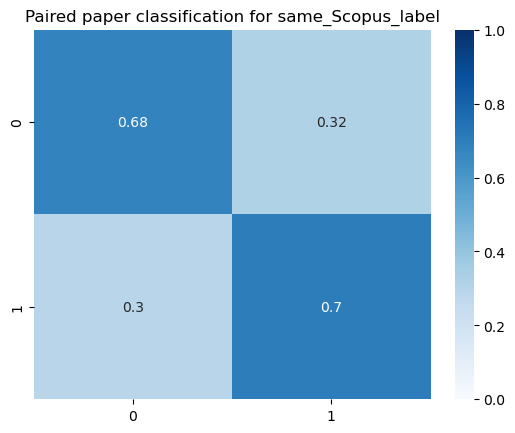

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
# evluation
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Paired paper classification for {label_column}")
plt.show()

In [30]:
from sklearn.model_selection import train_test_split
label_column = "same_movMF_label"

y = journal_pairs_df[label_column]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0       0.64      0.59      0.62      5071
           1       0.61      0.66      0.64      4929

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



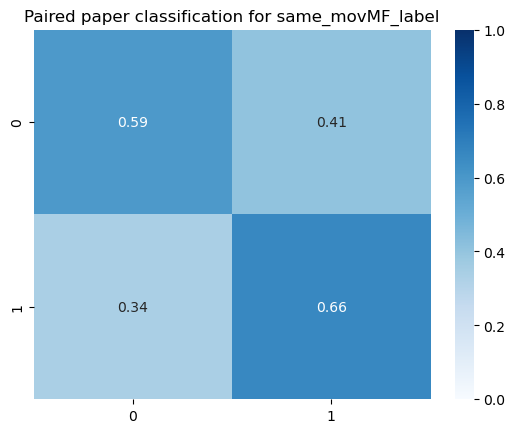

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
# evluation
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Paired paper classification for {label_column}")
plt.show()